In [1]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral

# load dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'

2024-06-20 12:33:53.909044: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 12:33:54.697664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 12:33:56.355526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0
[]


In [2]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Number of images in each class
print('Number of training images in each class:')
for c in classes:
    path = os.path.join(train_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
print('\nNumber of test images in each class:')
for c in classes:
    path = os.path.join(test_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
# Image size
img = cv2.imread('dataset/train/angry/Training_3908.jpg')
print(f'\nImage size: {img.shape}')

Number of training images in each class:
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
sad: 4830 images
surprise: 3171 images
neutral: 4965 images

Number of test images in each class:
angry: 958 images
disgust: 111 images
fear: 1024 images
happy: 1774 images
sad: 1247 images
surprise: 831 images
neutral: 1233 images

Image size: (48, 48, 3)


In [17]:
# CNN MODEL
input_layer = tf.keras.layers.Input(shape=(48, 48, 1))

# Erster konventioneller Convolutional Pfad
conv1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(input_layer)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.ReLU()(conv1)
conv1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)
dropout1 = tf.keras.layers.Dropout(0.3)(conv1)

# Zweiter konventioneller Convolutional Pfad
conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(dropout1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.ReLU()(conv2)
conv2 = tf.keras.layers.MaxPooling2D(2, 2)(conv2)
dropout2 = tf.keras.layers.Dropout(0.3)(conv2)

# # Dritter konventioneller Convolutional Pfad
# conv3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(conv2)
# conv3 = tf.keras.layers.BatchNormalization()(conv3)
# conv3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv3)
# conv3 = tf.keras.layers.MaxPooling2D(2, 2)(conv3)

# Paralleler Pfad mit Dilated Convolutions
# dilated1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', dilation_rate=3)(input_layer)
# dilated1 = tf.keras.layers.BatchNormalization()(dilated1)
# dilated1 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated1)
# dilated1 = tf.keras.layers.MaxPooling2D(2, 2)(dilated1)
# dropout1dilated = tf.keras.layers.Dropout(0.3)(dilated1)

# dilated2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', dilation_rate=3)(dropout1dilated)
# dilated2 = tf.keras.layers.BatchNormalization()(dilated2)
# dilated2 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated2)
# dilated2 = tf.keras.layers.MaxPooling2D(2, 2)(dilated2)
# dropout2dilated = tf.keras.layers.Dropout(0.3)(dilated2)

# dilated3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', dilation_rate=4)(dilated2)
# dilated3 = tf.keras.layers.BatchNormalization()(dilated3)
# dilated3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dilated3)
# dilated3 = tf.keras.layers.MaxPooling2D(2, 2)(dilated3)

# Zusammenführung der Pfade
merged = tf.keras.layers.concatenate([dropout2])

# Flatten und Dense Layers
flat = tf.keras.layers.Flatten()(merged)
dense1 = tf.keras.layers.Dense(256)(flat)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense1 = tf.keras.layers.ReLU()(dense1)
dropout = tf.keras.layers.Dropout(0.3)(dense1)
output = tf.keras.layers.Dense(7, activation='softmax')(dropout)

# Modell definieren
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_1 (Concatenate)     │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,719 (4.53 MB)

 Trainable params: 1,187,111 (4.53 MB)

 Non-trainable params: 608 (2.38 KB)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers

# DenseNet121 Modell ohne die oberste Klassifikationsschicht laden
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(48, 48, 1))

# Neue Modellspitze hinzufügen
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

# Modell kompilieren
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Zusammenfassung des Modells anzeigen
model.summary()

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models, optimizers

# ResNet50 Modell ohne die oberste Klassifikationsschicht laden
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(48, 48, 1))

# Neue Modellspitze hinzufügen
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

# Modell kompilieren
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Zusammenfassung des Modells anzeigen
model.summary()

In [4]:
import pathlib

# Function to decode and preprocess images
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [48, 48])
    img = img / 255.0  # Normalize to [0, 1]
    return img

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def encode_label(label, label_lookup):
    label_id = label_lookup(label)
    depth = tf.cast(label_lookup.vocabulary_size(), tf.int32)
    return tf.one_hot(label_id, depth=depth)

def prepare_label_lookup(train_dir):
    file_paths = tf.data.Dataset.list_files(str(pathlib.Path(train_dir) / '*/*'), shuffle=False)
    labels = file_paths.map(lambda x: tf.strings.split(x, os.path.sep)[-2])
    label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
    label_lookup.adapt(labels)
    return label_lookup

# Prepare label lookup
label_lookup = prepare_label_lookup(train_dir)

def process_path(file_path, label_lookup):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    label = encode_label(label, label_lookup)
    label = tf.cast(label, tf.int32)  # Ensure labels are integers
    print(f"Processed label dtype: {label.dtype}")  # Debugging-Ausgabe
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    print(f"Augmented label dtype: {label.dtype}")  # Debugging-Ausgabe
    return img, label

# Load original datasets
train_ds = tf.data.Dataset.list_files(str(pathlib.Path(train_dir) / '*/*.jpg'), shuffle=True)
train_ds = train_ds.map(lambda x: process_path(x, label_lookup), num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.list_files(str(pathlib.Path(test_dir) / '*/*.jpg'), shuffle=False)
test_ds = test_ds.map(lambda x: process_path(x, label_lookup), num_parallel_calls=tf.data.experimental.AUTOTUNE)

combined_train_ds = train_ds
augmented_train_ds = None
# Augment dataset
# for i in range(0):
#     augmented_train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#     # Combine original and augmented datasets
#     combined_train_ds = combined_train_ds.concatenate(augmented_train_ds)

# Shuffle, batch, and prefetch
combined_train_ds = combined_train_ds.shuffle(512).batch(64).prefetch(tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE).cache()

# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in combined_train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")

2024-06-20 12:35:11.788972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed label dtype: <dtype: 'int32'>
Processed label dtype: <dtype: 'int32'>
Image shape: (64, 48, 48, 1), Label dtype: <dtype: 'int32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'int32'>


2024-06-20 12:35:30.215138: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-20 12:35:30.282321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in augmented_train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")

2024-06-20 12:36:45.712017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-20 12:36:46.398448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 12:36:46.554594: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

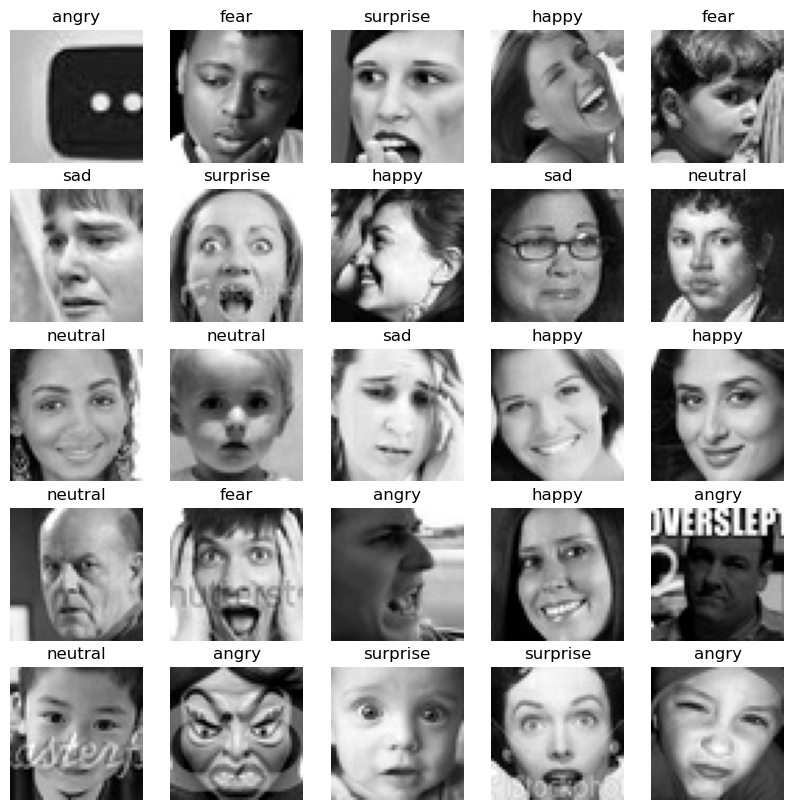

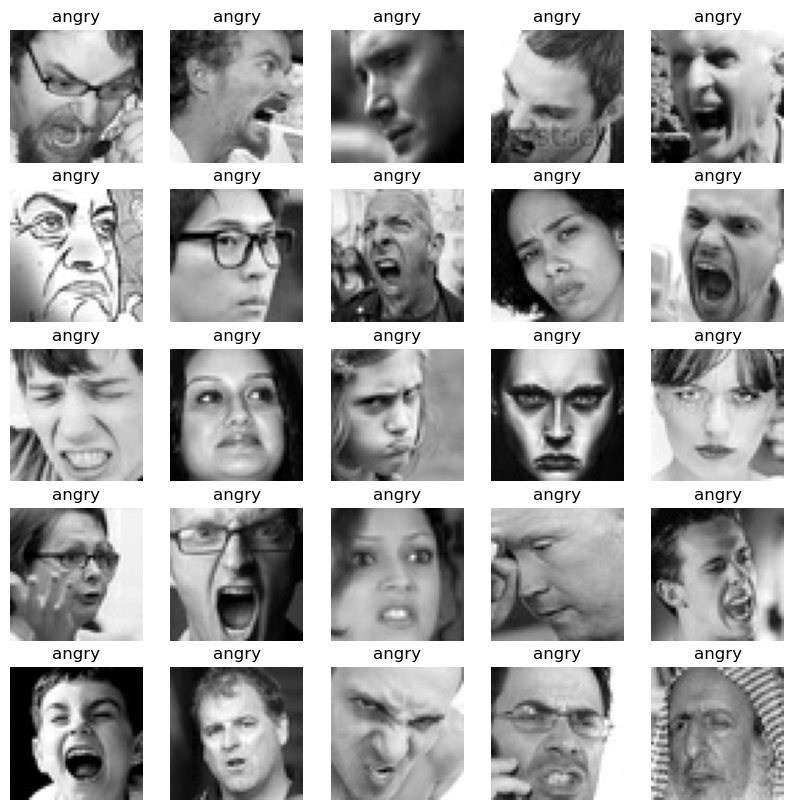

In [6]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch, label_lookup):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        # Show image as grayscale
        plt.imshow(tf.squeeze(image_batch[n]), cmap='gray')
        label = label_lookup.get_vocabulary()[tf.argmax(label_batch[n]).numpy()]
        plt.title(label)
        plt.axis("off")

# Eine Stichprobe aus dem Trainingsdatensatz anzeigen
for image_batch, label_batch in combined_train_ds.take(1):
    show_batch(image_batch, label_batch, label_lookup)

for image_batch, label_batch in test_ds.take(1):
    show_batch(image_batch, label_batch, label_lookup)

In [6]:
import collections

def get_class_distribution(dataset):
    class_counts = collections.Counter()
    
    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())
    
    return class_counts

# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(combined_train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


2024-06-19 20:50:50.163959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Class Distribution: Counter({0: 14430, 1: 9930, 2: 9660, 3: 8194, 4: 7990, 5: 6342, 6: 872})
Test Class Distribution: Counter({0: 1774, 2: 1247, 1: 1233, 3: 1024, 4: 958, 5: 831, 6: 111})


2024-06-19 20:50:51.730607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
from sklearn.utils import class_weight

# Load test data
x_train = []
y_train = []

for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        # img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            # img = cv2.resize(img, (48, 48))
            # x_train.append(img)
            y_train.append(i)

In [9]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}
Type of keys: <class 'int'>
Type of values: <class 'float'>


In [10]:
# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, mode='min')


In [11]:
for image, label in train_ds.take(1):  # Only take the first batch
    print(label)  # Show the label

tf.Tensor([1 0 0 0 0 0 0], shape=(7,), dtype=int32)


2024-06-20 12:44:56.772635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [58]:
history = model.fit(
    combined_train_ds,
    # class_weight=class_weights_dict,
    epochs=5,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

TypeError: true_fn and false_fn arguments to tf.cond must have the same number, type, and overall structure of return values.

true_fn output: Tensor("cond/Identity:0", shape=(None,), dtype=int64)
false_fn output: Tensor("cond/Identity:0", shape=(None,), dtype=int32)

Error details:
Tensor("cond/Identity:0", shape=(None,), dtype=int64) and Tensor("cond/Identity:0", shape=(None,), dtype=int32) have different types

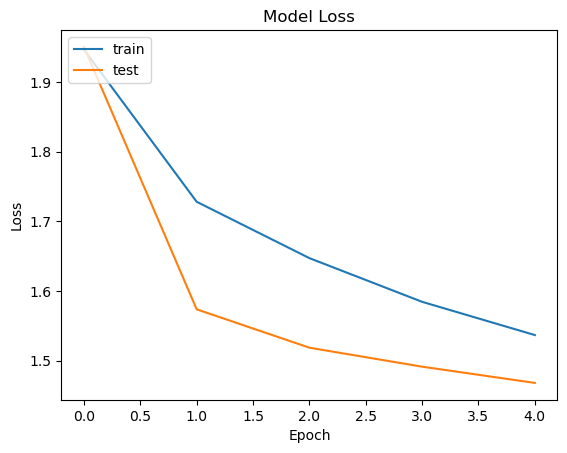

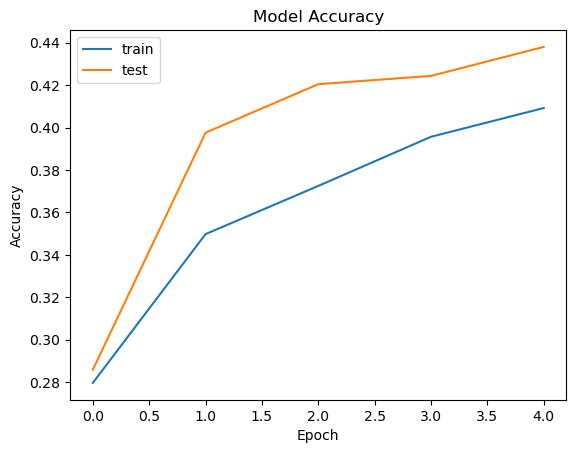

In [20]:
# Plot training history (loss and accuracy)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            img = cv2.resize(img, (48, 48))
            # Image to greyscale and shape (48, 48, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


Model saved as emotion_recognition_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0407 - loss: 247.7368
[248.5944366455078, 0.02883811667561531]
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.02      0.96      0.03       111
           2       0.00      0.00      0.00      1024
           3       0.20      0.05      0.08      1774
           4       0.26      0.01      0.01      1247
           5       0.13      0.01      0.01       831
           6       0.00      0.00      0.00      1233

    accuracy                           0.03      7178
   macro avg       0.09      0.15      0.02      7178
weighted avg       0.11      0.03      0.02      7178

Confusion Matrix:
 [[   0  841    0   99   10    8    0]
 [   0  107    0    2    2    0    0]
 [   0  925    0   89    2    8    0]
 [   2 1677    0   85    4    6    0]
 [  

/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

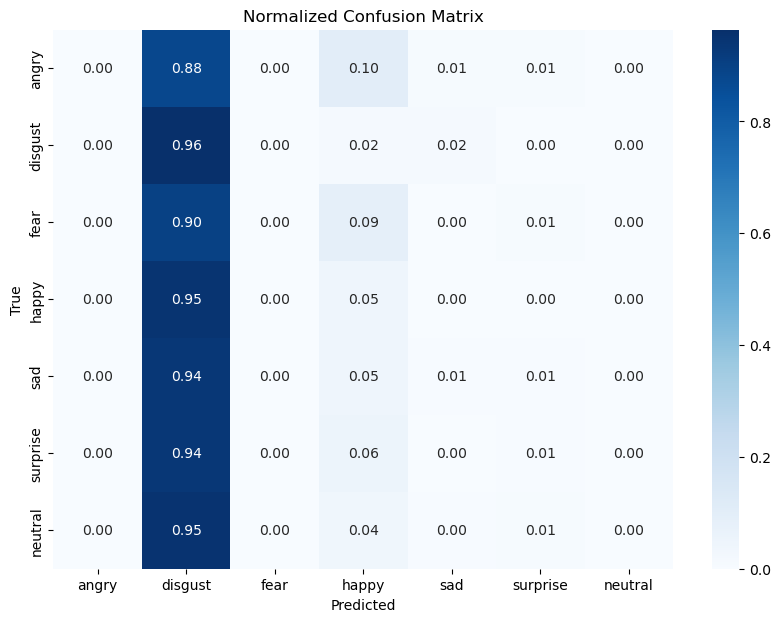

Image shape: (48, 48)


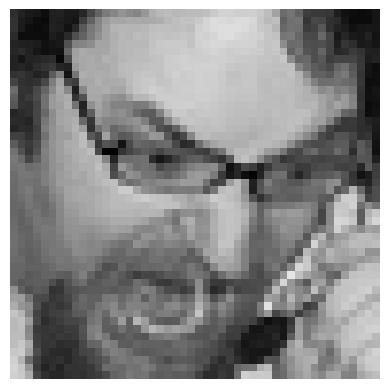

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted emotion: angry


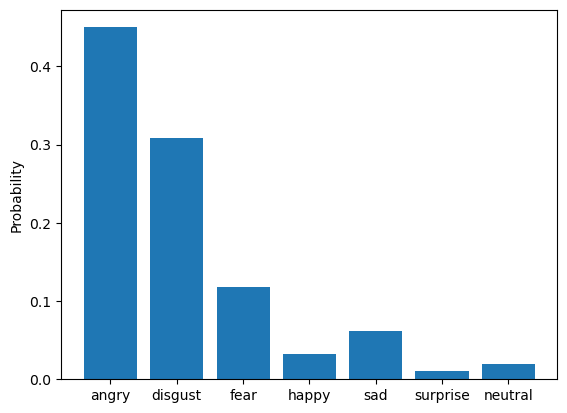

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


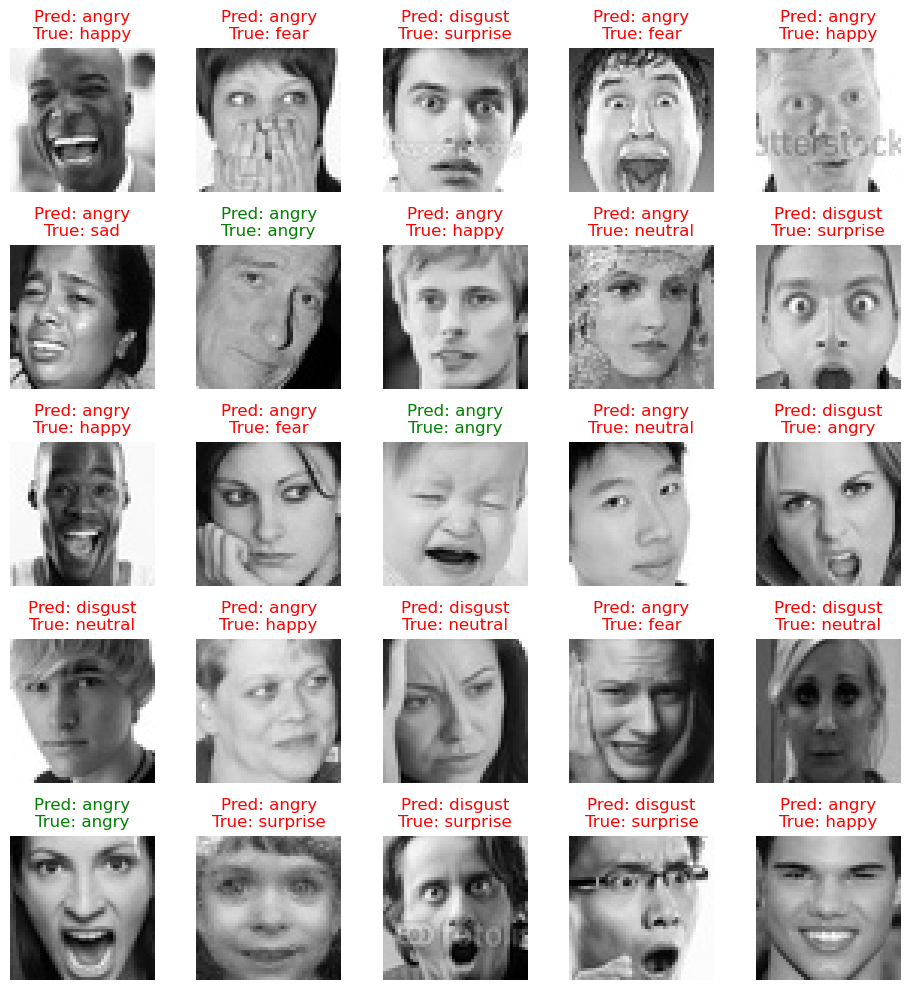

In [57]:
if history is not None:

    # PLOT TRAINING AND VALIDATION ACCURACY
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # PLOT TRAINING AND VALIDATION LOSS
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Zugreifen auf die Metriken im Trainingsverlauf
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    # Beispielausgabe der Genauigkeit
    print("Training Accuracy:", accuracy)
    print("Validation Accuracy:", val_accuracy)


# SAVE MODEL, if model is defined

if model is not None: 
    model.save('emotion_recognition_model.h5')
    print('Model saved as emotion_recognition_model.h5')
else:
    # Load model
    model = tf.keras.models.load_model('emotion_recognition_model.h5')
    print('Model loaded from emotion_recognition_model.h5')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
# Evaluiere das Modell
evaluation = model.evaluate(x_test, y_test_encoded)

# Evaluationsergebnisse anzeigen
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print('Classification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# TEST MODEL
# Load test image
file_path = 'dataset/test/angry/PrivateTest_88305.jpg'
img = x_test[0]
print(f'Image shape: {img.shape}')

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

img = np.reshape(img, [1, 48, 48, 1])
img = img / 255.0  # Normalize to [0, 1]
# Predict emotion
prediction = model.predict(img)
emotion = classes[np.argmax(prediction)]
print(f'Predicted emotion: {emotion}')

# Display prediction
plt.bar(classes, prediction[0])
plt.ylabel('Probability')
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img = np.reshape(img, [1, 48, 48, 1])
    img = img / 255.0  # Normalize to [0, 1]
    prediction = model.predict(img)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = 'g' if emotion == true_emotion else 'r'
    plt.imshow(cv2.cvtColor(x_test[index], cv2.COLOR_BGR2RGB))
    plt.title(f'Pred: {emotion}\nTrue: {true_emotion}', color=color)
    plt.axis('off')
    plt.tight_layout()
    
plt.show()